<b>Data Sources</b>
* Data on parcels from [San Bernardino Open Data Portal](https://open.sbcounty.gov/datasets/countywide-parcels/about) and <>INSERT SOURCE FOR RIVERSIDE HERE<>
* Shapefiles for National Highway Freight Network from [Federal Highway Administration ](https://fpcb.ops.fhwa.dot.gov/tools_nhfn.aspx)
* Data on warehouse locations and year built from [Warehouse CITY](https://radicalresearch.shinyapps.io/WarehouseCITY)

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

<b>Part 1: Merge Assessor Parcels Together</b>

Import Riverside data and clean it up so that it matches San Bernardino data

In [207]:
# import data for all parcels in Riverside County
riverside = gpd.read_file('riversideparcels/riversideparcels.shp')
# set APN to be the index
riverside.set_index('APN',inplace=True)
# drop unneccessary columns
riverside=riverside[['LAND','geometry']]
# rename columns to match san bernardino parcels
riverside.rename(columns={'LAND':'LAND_VALUE'},inplace=True)
# check if APN is unique
print(riverside.index.is_unique)
riverside.head(5)

True


,LAND_VALUE,geometry
APN,,
101020003,913089.0,"POLYGON ((6144418.489 2282740.357, 6144418.117..."
101030005,71609.0,"POLYGON ((6148748.783 2277997.776, 6148761.957..."
101020005,249728.0,"POLYGON ((6135980.318 2280787.576, 6136129.368..."
101030007,9027.0,"POLYGON ((6148745.188 2277443.456, 6148115.179..."
101040001,20601.0,"POLYGON ((6136604.245 2277632.378, 6136592.169..."


Import San Bernardino data and clean it up so that it matches Riverside data

In [4]:
# import data for all parcels in San Bernadino County downloaded from https://open.sbcounty.gov/datasets/countywide-parcels/about.
sanbernardino = gpd.read_file('data/countywide_parcels/pbmpoly.shp')
# keep just columns we need to reduce file size
sanbernardino=sanbernardino[['APN','LAND_VALUE', 'geometry']]
# set APN to be the index
sanbernardino.set_index('APN',inplace=True)
# check that it is unique
sanbernardino.index.is_unique

False

In [211]:
# dissolve parcel subdivisions
sanbernardino = sanbernardino.dissolve(by='APN',aggfunc={"LAND_VALUE": 'sum'})
print(sanbernardino.index.is_unique)
sanbernardino.head()

True


,geometry,LAND_VALUE
APN,,
0,"MULTIPOLYGON (((6675849.369 1871817.069, 66758...",0.0
10829107,"POLYGON ((6675457.139 1853449.721, 6676118.522...",0.0
10829113,"POLYGON ((6676118.522 1853450.723, 6676250.489...",0.0
10829114,"POLYGON ((6676250.489 1853450.923, 6676382.774...",0.0
10830101,"POLYGON ((6674319.167 1852831.711, 6674435.145...",152000.0


Concatenate the two datasets!

In [354]:
# riverside and san bernardino have different projections, but we're going to go with san bernardino (2229) because it's the same as LA County
riverside=riverside.to_crs(2229)
# concatenate
parcels = pd.concat([riverside, sanbernardino])
parcels.sample(5)

,LAND_VALUE,geometry
APN,,
149210042,76927.0,"POLYGON ((6715601.562 1799317.123, 6715657.183..."
686161005,105068.0,"POLYGON ((7025215.434 1742860.116, 7025146.182..."
309728111,54241.0,"POLYGON ((6714186.569 1998979.332, 6714351.048..."
23329302,69888.0,"POLYGON ((6725796.688 1852486.153, 6725921.675..."
685351015,20.0,"POLYGON ((7047297.883 1750851.357, 7047297.247..."


In [223]:
print(len(riverside)+len(sanbernardino)==len(parcels))

True


<b>Part 2: Calculate Distance to Freight</b><br>
Here we use shapefiles of the locations of the National Highway Freight Network to calculate the distance from each parcel to the network.

In [237]:
freight = gpd.read_file('data/NHFN_GIS_Shapefiles_Jan_2022/PublicRelease/National-NHFN-2022.shp')
# Keep just columns we need to reduce file size.
freight=freight[['NHFN_CODE','geometry']]
# join info about nearest freight route to each parcel 
parcels = gpd.sjoin_nearest(parcels, freight.to_crs(2229), how='left',rsuffix='freight',distance_col="distances",max_distance=400000)

Text(0.5, 1.0, 'Distance to National Highway Freight Network')

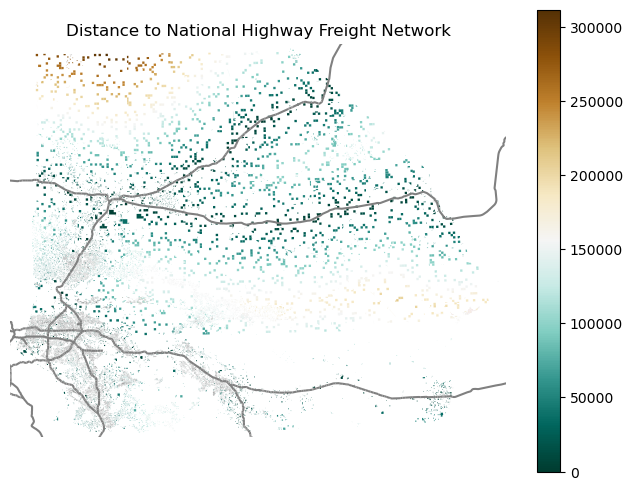

In [238]:
# plot 10% of parcels (to reduce drawing time) to make sure results seem reasonable
minx, miny, maxx, maxy = parcels.geometry.total_bounds
fig, ax = plt.subplots(figsize=(8, 6))
parcels.sample(frac=0.1).plot(ax=ax,column='distances',legend=True,cmap='BrBG_r')
freight.to_crs(2229).plot(ax=ax,color='grey')
ax.axis('off')
ax.set_xlim(minx-10000,maxx+10000)
ax.set_ylim(miny-10000,maxy+10000)
ax.set_title('Distance to National Highway Freight Network')
#ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

<b>Part 3: Determine Presence of Warehouses</b>

In [355]:
# import warehouse data downloaded from Warehouse City (https://radicalresearch.shinyapps.io/WarehouseCITY/)
warehouses = pd.read_csv('data/Warehouse_List.csv')

# rename columnn names so that they don't have spaces and are easier to work with
warehouses.rename(columns={'Assessor parcel number':'APN','Building classification':'building_class','Year built':'year',
                           'Acres':'acres','Building sq.ft.':'sqft'},inplace=True)
warehouses.head()

,Category,APN,building_class,year,acres,sqft
0,Planned and Approved,World Logistics Center,TBD,2025,2650,63499000
1,Planned and Approved,Legacy Highlands Phase II Specific Plan,TBD,2025,1386,33207000
2,Planned and Approved,Airport Gateway Specific Plan Area,TBD,2025,613,14689000
3,Planned and Approved,Stoneridge Commerce Center,TBD,2025,606,14523000
4,Planned and Approved,Speedway Commerce Center,TBD,2025,464,11118000


Between the simple maps above and some additional research in the [County Zoning District Maps](https://sbcounty.maps.arcgis.com/apps/MapSeries/index.html?appid=f5a50c44766b4c36a3ae014497aa430d) we have confirmed that the duplicated Assessor Numbers are associated with parcels with multiple subdivisions with warehouses on them. We want our analysis to take place at the parcel level, so we will aggregate our data accordingly.

In [356]:
# get category and buiding class associated with each parcel.
warehouse_parcels=warehouses.groupby('APN')[['Category','building_class']].first()
# get first year that a warehouse was built on the parcel.
year=warehouses.groupby('APN')[['year']].min()
# get total acres of warehouses built on the parcel.
area=warehouses.groupby('APN')[['acres','sqft']].sum()
# get number of warehouses
num_warehouses=warehouses.groupby('APN').size()
num_warehouses.name='num_warehouses'
# join all of these column together on parcel_id.
warehouse_parcels=warehouse_parcels.join(year).join(area).join(num_warehouses)
warehouse_parcels.sample(5)

,Category,building_class,year,acres,sqft,num_warehouses
APN,,,,,,
6129-002-027,Existing,"Warehousing, Distribution, Storage",1980,1,34000,1
330030020,Existing,ct-light industrial,1997,53,1262000,1
063307119,Existing,storage building,2003,5,119000,1
7339-013-019,Existing,"Warehousing, Distribution, Storage",1980,3,69000,1
8264-015-065,Existing,"Warehousing, Distribution, Storage",1996,4,103000,1


In [357]:
#making sure Riverside example parcel is present
check3 = warehouse_parcels[warehouse_parcels.index=='156030046']
check3

,Category,building_class,year,acres,sqft,num_warehouses
APN,,,,,,
156030046,Existing,light industrial,2014,9,223000,1


In [358]:
# use lambda functions to denote whether warehouse had been built on each parcel by 2010 and by 2020.
warehouse_parcels['warehouse_2010']=warehouse_parcels.year.apply(lambda x: True if x<=2010 else False)
warehouse_parcels['warehouse_2020']=warehouse_parcels.year.apply(lambda x: True if x<=2020 else False)
warehouse_parcels['built_2010s']=warehouse_parcels.year.apply(lambda x: True if (2010 <= x <= 2020) else False)
# check to see that this has worked.
warehouse_parcels.head()

,Category,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s
APN,,,,,,,,,
011011113,Existing,storage warehouse,2021,2,41000,1,False,False,False
011011114,Existing,storage warehouse,2021,2,39000,1,False,False,False
011012110,Existing,distribution warehouse,1982,4,106000,1,True,True,False
011031145,Existing,distribution warehouse,2016,8,187000,1,False,True,True
011031146,Existing,distribution warehouse,2016,25,589000,1,False,True,True


In [364]:
#Need to do some manipulations of indexes for the join. First, pull the APN column out of the indices so we can edit them. 
warehouse_parcels = warehouse_parcels.reset_index()
parcels = parcels.reset_index()

In [362]:
#Now, remove the dashes and any non-numeric columns so we can have better matches. 
warehouse_parcels['APN'] = warehouse_parcels['APN'].apply(lambda x: x.replace("-",""))
warehouse_parcels = warehouse_parcels[warehouse_parcels.APN.apply(lambda x: x.isnumeric())]

In [365]:
#Change the APN column to float in both the warehouses and parcels dfs so we can join them (stirng and int gave me trouble)
warehouse_parcels['APN'] = warehouse_parcels['APN'].astype('float')
parcels['APN'] = parcels['APN'].astype('float')
print(parcels['APN'].dtypes)
print(test['APN'].dtypes)

In [370]:
parcels_warehouses=parcels.join(warehouse_parcels.set_index('APN'), how = 'left', on = 'APN')
parcels_warehouses.head(5)

,APN,LAND_VALUE,geometry,index,Category,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s
0,101020003.0,913089.0,"POLYGON ((6675304.883 1795077.351, 6675305.019...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101030005.0,71609.0,"POLYGON ((6679714.894 1790408.618, 6679693.702...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101020005.0,249728.0,"POLYGON ((6666900.781 1792982.099, 6667059.025...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101030007.0,9027.0,"POLYGON ((6679720.680 1789854.303, 6679090.649...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101040001.0,20601.0,"POLYGON ((6667577.981 1789837.830, 6667588.369...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [371]:
check6 = parcels_warehouses[parcels_warehouses.APN==156030029]
check6 #checing again to make sure Riverside warehouse example is here, it looks good!

,APN,LAND_VALUE,geometry,index,Category,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s
97775,156030029.0,14903838.0,"POLYGON ((6700449.361 1830840.949, 6699523.730...",2603.0,Existing,light industrial,1980.0,63.0,1502000.0,1.0,True,True,False


Map to ensure that this looks like Warehouse City (map below is screenshot)

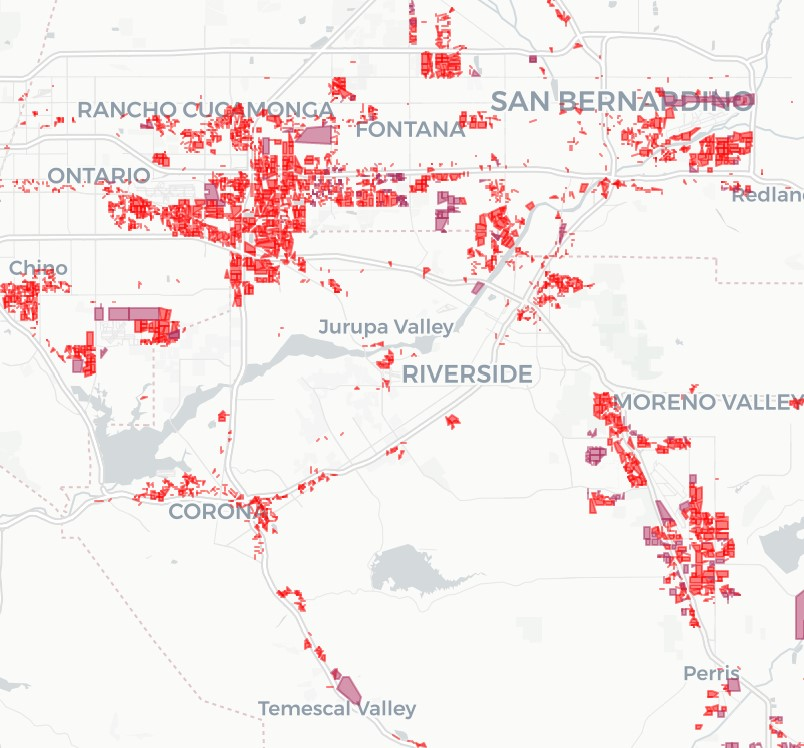

In [250]:
counties=gpd.read_file('data/CA_Counties/CA_Counties_TIGER2016.shp')
counties=counties[counties.NAME.apply(lambda x: True if x in ('Riverside','San Bernardino') else False)]

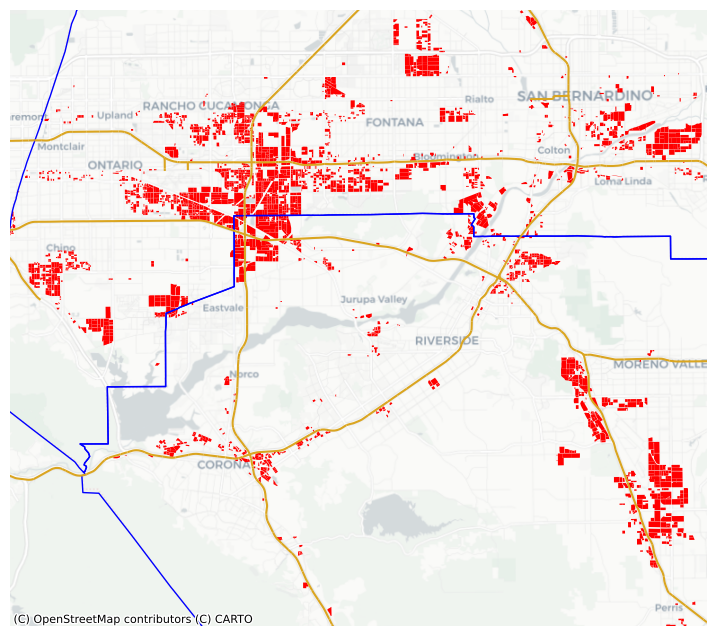

In [372]:
fig, ax = plt.subplots(figsize=(10, 8))
parcels_warehouses[parcels_warehouses['num_warehouses']>0].plot(ax=ax,color='red')
freight.to_crs(2229).plot(ax=ax,color='#daa520')
counties.plot(ax=ax,color='none')
counties.to_crs(2229).plot(ax=ax,color='none',edgecolor='blue')
ax.axis('off')
ax.set_xlim(6643710, 6804764)
ax.set_ylim(1740000,1882403)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

San Bernardino is looking pretty good, but it looks like there are no warehouses in Riverside which we know isn't true :( 
To start troubleshooting, I used the [Riverside Assessor Database](https://ca-riverside-acr.publicaccessnow.com/Search.aspx?s=156030048&pg=1&g=-1&moduleId=478) to search for some three parcels that I knew were 1) in Riverside County, and 2) had warehouses on them (found examples on Warehouse CITY website). All three of these did return matches on the Riverside Assessor Database but are missing from the Riverside parcel data:
* 156030029 
* 156030046
* 156030048

This means that these parcels got lost somewhere earlier in the process that when I uploaded them into this notebook :(


*Troubleshooting explained*: Somehow I think the APN on SB vs Riverside were different data types, and this caused some issues with joining the APNs when the warehouse parcels were brought in. By reseting indices and changing the types to all Float, as well as dropping dashes and non-numeric characters in the Warehouses APN, we got better matches and were able to map both counties. 

In [ ]:
# saving new file
parcels_warehouses.to_file('data/parcels_warehouses.geojson')